In [1]:
import cv2
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import re

from color_gradient_thresholds import abs_sobel_thresh, mag_thresh, dir_threshold, hls_select, rgb_select

%matplotlib inline



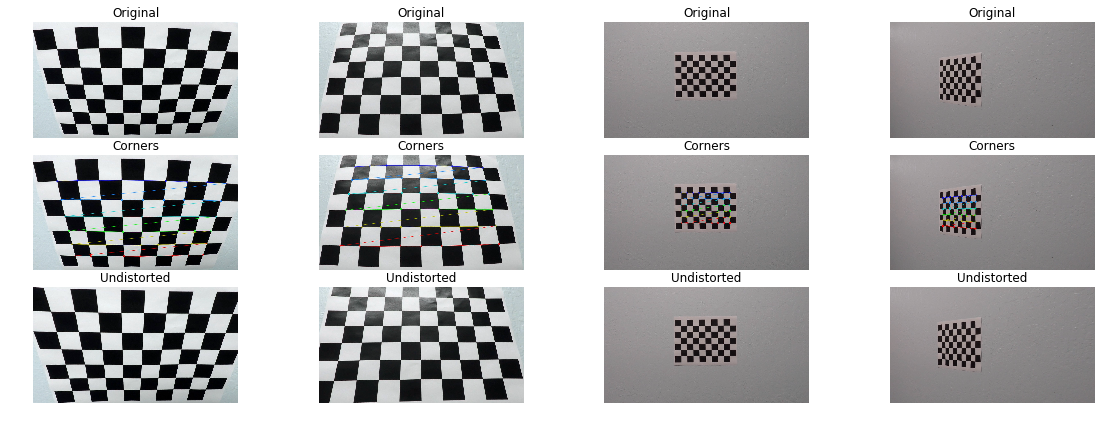

In [2]:

def calibration():
    """
    Using the chessboard images found in "./camera_cal/calibration*.jpg", finds chessboard corners in each image, creates new image "corners_found*.jpg" with corners drawn
    Then finds and saves the camera's matrix and distortion coefficients in "calibration.p" pickle file
    Finally, undistorts chessboard images and save them as "undistorted*.jpg"
    """
    
    calibration_images = glob.glob('./camera_cal/calibration*.jpg')
    
    # prepare object points
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.


    for fname in calibration_images:
        
        idx = int(re.search(r'\d+', fname).group())
        
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = './camera_cal/corners_found{}.jpg'.format(idx)
            cv2.imwrite(write_name, img)

    img = cv2.imread('./camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])

    ret , mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open("./calibration.p", "wb"))


    #undistort chessboard images
    for fname in calibration_images:
        idx = int(re.search(r'\d+', fname).group())
        img = cv2.imread(fname)
        img = cv2.undistort(img, mtx, dist,None, mtx)
        write_name = './camera_cal/undistorted{}.jpg'.format(idx)
        cv2.imwrite(write_name, img)

        
        
def display_calibration():
    """
    Displays results of calibration function
    """
    calibration_images = glob.glob('./camera_cal/calibration*.jpg')
    corners_images = glob.glob('./camera_cal/corners_found*.jpg')
    undistorted_images = glob.glob('./camera_cal/undistorted*.jpg')
   
    sample_indices = [2,3,6,7]
    sample_length = len(sample_indices)
    
    fig, axs = plt.subplots(3, 4, figsize=(20,7))
    fig.subplots_adjust(hspace = .15, wspace=0.1)
    axs = axs.ravel()
    for i, index in enumerate(sample_indices):
        original = cv2.imread('./camera_cal/calibration{}.jpg'.format(index))
        corners = cv2.imread('./camera_cal/corners_found{}.jpg'.format(index))
        undistorted = cv2.imread('./camera_cal/undistorted{}.jpg'.format(index))
        axs[i].imshow(original)
        axs[i+sample_length].imshow(corners)
        axs[i+sample_length*2].imshow(undistorted)
        axs[i].axis('off')
        axs[i].set_title("Original")
        axs[i+sample_length].axis('off')
        axs[i+sample_length].set_title("Corners")
        axs[i+sample_length*2].axis('off')
        axs[i+sample_length*2].set_title("Undistorted")
 
    plt.show()
        
#calibration()
display_calibration()
dist_pickle = pickle.load(open("camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [3]:
def save_img(img, line_tracker):
    """
    Saves videos images to local folder
    """
    
    write_name = './project_video_images/{}_img{}.jpg'.format(video, line_tracker.index)
    cv2.imwrite(write_name, cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
    line_tracker.index += 1
    


def save_images(img):
    save_img(img, lt)
    return img

def generate_images_from_video(video):
    clip = VideoFileClip('./project_videos/{}.mp4'.format(video))
    video_clip = clip.fl_image(save_images)
    video_clip.write_videofile('./project_video_images/{}.mp4'.format(video), audio=False)

    
#lt = line_tracker() 
#video = 'project_video'
#video = 'challenge_video'
#video = 'harder_challenge_video'
#generate_images_from_video(video)

In [4]:
class line_tracker():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        self.number_of_misses = 4
        self.all_left_fit = []
        self.all_right_fit = []
        self.index = 0




    def find_lane_lines(self, img, binary_warped, Minv):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []


        #if we detected a high-confidence lane line in any of hte last 3 frames, skip the windowing
        # technique and use average of last 3 high confidence lane line fit to look for lane lines in this frame
        #print(self.detected)
        if (self.number_of_misses < 4):
            history = len(self.all_left_fit)
            left_fit = None
            right_fit = None
            if history == 1:
                left_fit = self.all_left_fit[history-1]
                right_fit = self.all_right_fit[history-1]
            if history == 2:
                l1 = self.all_left_fit[history-1]
                l2 = self.all_left_fit[history-2]
                left_fit = (l1 + l2 )/2
                r1 = self.all_right_fit[history-1]
                r2 = self.all_right_fit[history-2]
                right_fit = (r1 + r2 )/2
            if (history == 3) | (history > 3):
                l1 = self.all_left_fit[history-3]
                l2 = self.all_left_fit[history-2]
                l3 = self.all_left_fit[history-1]
                left_fit = (l1 + l2 + l3)/3
                r1 = self.all_right_fit[history-1]
                r2 = self.all_right_fit[history-2]
                r3 = self.all_right_fit[history-3]
                right_fit = (r1 + r2 + r3)/3


            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        else:

            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        #visualize lane line detection on perspective transform
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        if self.detected:
            window_img = np.zeros_like(out_img)
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)



        y_eval = np.max(ploty)
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        #Now in meters

        #lane line sanity checks -
        #similar curvature (roughly parallel)? for lines with a radius of < 10,000 meters (non-straight), radius difference is < 400
        #separated by the right distance horizontally? left-right fit is < 750 pixels and > 500
        if (((left_curverad < 10000) & (np.absolute(left_curverad - right_curverad) > 400)) | ((((right_fitx[-1] - left_fitx[-1]) > 750)) | ((right_fitx[-1] - left_fitx[-1]) < 500))):
            self.detected = False
            self.number_of_misses = self.number_of_misses + 1
        else:
            self.detected = True
            self.number_of_misses = 0
            self.all_left_fit.append(left_fit)
            self.all_right_fit.append(right_fit)

        img_size = (img.shape[1], img.shape[0])

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        cv2.fillPoly(color_warp, np.int_([pts_left]), (255,0, 0))
        cv2.fillPoly(color_warp, np.int_([pts_right]), (0,0, 255))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, img_size)
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 1.0, 0)

        #plt.imshow(out_img)
        #plt.show()
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #plt.show()

        camera_center = (left_fitx[-1] + right_fitx[-1])/2

        center_diff = (camera_center - binary_warped.shape[1]/2)*xm_per_pix
        side_pos = 'left'
        if center_diff <= 0:
            side_pos = 'right'

        cv2.putText(result, 'Radius of curvature: Left = ' + str(round(left_curverad, 1)) + 'm   Right = ' + str(round(right_curverad, 1)) + 'm', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.putText(result, 'Vehicle is ' + str(round(center_diff, 3)) + 'm ' + side_pos + ' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)


        return result, out_img


In [58]:
def pipeline(img, line_tracker):
    
    
    
    #####################################
    #Undistort Image
    #####################################
    img = cv2.undistort(img, mtx, dist,None, mtx)
    
    
    #####################################
    # Apply Gradient and Color Thresholds
    #####################################

    rgb_r_binary = rgb_select(img, channel=0, thresh=(220, 255))
    hls_s_binary = hls_select(img, channel=2, thresh=(110, 255))
    hls_h_binary = hls_select(img, channel=0, thresh=(20, 50))
    
    gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=9, thresh=(15, 100))
    grady_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=9, thresh=(25, 100))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 80))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.85, 1.25))
    #combined_binary = np.zeros_like(gradx_binary)
    #combined_binary[((gradx_binary ==1) & (mag_binary==1)) | ((hls_s_binary ==1) & (dir_binary ==1))] = 1
    
    combined_binary1 = np.zeros_like(gradx_binary)
    combined_binary2 = np.zeros_like(gradx_binary)
    combined_binary3 = np.zeros_like(gradx_binary)
    combined_binary4 = np.zeros_like(gradx_binary)
    combined_binary1[((rgb_r_binary == 1) & (hls_s_binary == 1)) | ((gradx_binary == 1) & (mag_binary ==1))] = 1
    combined_binary2[((gradx_binary ==1) & (mag_binary==1)) | ((hls_s_binary ==1) & (dir_binary ==1))] = 1
    combined_binary3[(hls_s_binary == 1) | (gradx_binary ==1)] = 1
    combined_binary4[((gradx_binary ==1) & (dir_binary==1)) | ((hls_s_binary ==1) & (mag_binary ==1)) ] = 1
    #return combined_binary1,combined_binary2,combined_binary3,combined_binary4
    
    
    #####################################
    #Perspective Transform
    #####################################
    img_size = (img.shape[1], img.shape[0])
    bot_width = .76
    mid_width = .08
    height_pct = .62
    bottom_trim = .935
    src = np.float32([[img.shape[1]*(.5-mid_width/2), img.shape[0]*height_pct], [img.shape[1]*(.5+mid_width/2), img.shape[0]*height_pct], [img.shape[1]*(.5+bot_width/2), img.shape[0]*bottom_trim], [img.shape[1]*(.5-bot_width/2), img.shape[0]*bottom_trim] ])
    offset = img_size[0]*.15
    dst = np.float32([[offset,0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped_binary1 = cv2.warpPerspective(combined_binary1, M, img_size, flags=cv2.INTER_LINEAR)
    warped_binary2 = cv2.warpPerspective(combined_binary2, M, img_size, flags=cv2.INTER_LINEAR)
    warped_binary3 = cv2.warpPerspective(combined_binary3, M, img_size, flags=cv2.INTER_LINEAR)
    warped_binary4 = cv2.warpPerspective(combined_binary4, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_binary1,warped_binary2,warped_binary3,warped_binary4
    
    
    #####################################
    #Find lane lines
    #####################################
    result, out_img = line_tracker.find_lane_lines(img, warped_binary, Minv)

    
    
    
    #####################################
    #Draw back on original image
    #####################################
    x_offset = 50
    y_offset = 150
    l_img = result
    s_img = cv2.resize(out_img, None, fx=.2, fy=.2)
    l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], 0] = s_img[:,:,0]
    l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], 1] = s_img[:,:,1]
    l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], 2] = s_img[:,:,2]


    for c in range(0,2):
        l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], c] = s_img[:,:,c] * (s_img[:,:,2]/255.0) +  l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1], c] * (1.0 - s_img[:,:,2]/255.0)

    return l_img

In [6]:
lt = line_tracker()

def run_pipeline(img):
    return pipeline(img, lt)

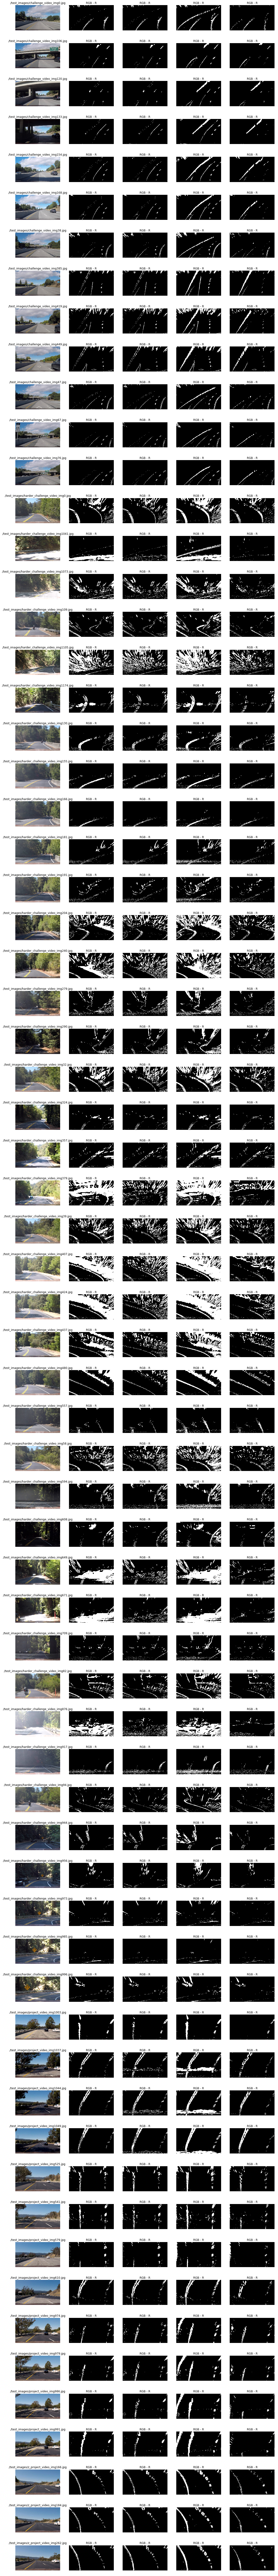

In [59]:
def run_pipeline_on_images(fnames):
    img_count = len(fnames)
    fig, axs = plt.subplots(img_count, 5, figsize=(20, img_count*3))
    axs = axs.ravel()
    for i, fname in enumerate(fnames):

        img = cv2.imread(fname)
        x1, x2, x3, x4 = pipeline(img, lt)
        
        axs[i*5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i*5].set_title(fname)
        axs[i*5+1].imshow(x1, cmap='gray')
        axs[i*5+1].set_title('RGB - R')
        axs[i*5+2].imshow(x2, cmap='gray')
        axs[i*5+2].set_title('RGB - R')
        axs[i*5+3].imshow(x3, cmap='gray')
        axs[i*5+3].set_title('RGB - R')
        axs[i*5+4].imshow(x4, cmap='gray')
        axs[i*5+4].set_title('RGB - R')
        
        
        axs[i*5].axis('off')
        axs[i*5+1].axis('off')
        axs[i*5+2].axis('off')
        axs[i*5+3].axis('off')
        axs[i*5+4].axis('off')
        
        #write_name = './processed_images/{}_processed.jpg'.format(fname)
        #cv2.imwrite(write_name, result)

#images = glob.glob('./project_video_images/project_video_img*.jpg')
images = glob.glob('./test_images/*.jpg')
run_pipeline_on_images(images)

In [ ]:
def run_pipeline_on_video(input_video, output_video):
    clip = VideoFileClip(input_video)
    video_clip = clip.fl_image(run_pipeline)
    video_clip.write_videofile(output_video, audio=False)

    
video = 'project_video'
#video = 'challenge_video'
#video = 'harder_challenge_video'
run_pipeline_on_video('./project_videos/{}.mp4'.format(video), './processed_videos/{}.mp4'.format(video))